In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score,roc_auc_score,roc_curve, recall_score,make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

In [2]:
# defining all the required functions

def plot_curve(model, X_test, y_test,score, model_label):
    
    # function to plot roc curve for the given model
    y_score = pd.DataFrame(model.predict_proba(X_test))[1]
    fpr,tpr, threshold = roc_curve(y_test, y_score)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label='{} {}'.format(model_label,np.round(score,2)))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('roc.png')

def gridfunc(classifier, parameter, X_train, y_train):
    
    # custom GridSearcg function
    clf = classifier
    np.random.seed(9)
    parameters = parameter
    acc_scorer = make_scorer(roc_auc_score)
    
    # Run the grid search
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
    grid_obj = grid_obj.fit(X_train, y_train)
    
    return grid_obj

def hp_cv_scores(grid_obj):
    grid_obj.cv_results_
    mean_test_scores = grid_obj.cv_results_['mean_test_score']
    mean_train_scores = grid_obj.cv_results_['mean_train_score']
    print(mean_test_scores.max())
    
def cat_univariate_eda(df, cat_col_names, n_cols = 3, figsize = None, save_fig = False):
    
    # univariate eda for categorical features
    n_rows = len(cat_col_names)/n_cols
    
    plt.figure(figsize=(5*n_cols,5*n_rows))
    
    if figsize:
        plt.figure(figsize=figsize)
    
    for i in range(0,len(cat_col_names)):
        plt.subplot(n_rows+1, n_cols, (i+1))
        sns.countplot(df[cat_col_names[i]])
    
    if save_fig:
        plt.savefig('./cat_col_eda1.png')
    
    plt.show()
    
    
def num_univariate_eda(df, num_col_names, n_cols = 4, figsize = None, save_fig = False):
    
    # univariate eda for numerical features
    n_rows = len(num_col_names)/n_cols
    
    plt.figure(figsize=(5*n_cols,5*n_rows))
    
    if figsize:
        plt.figure(figsize=figsize)
    
    for i in range(0,len(num_col_names)):
        plt.subplot(n_rows+1, n_cols, (i+1))
        sns.distplot(df[num_col_names[i]].dropna(), kde=True)
        #sns.boxplot(y=df[num_col_names[i]].dropna())
    
    
    if save_fig:
        plt.savefig('./num_col_eda.png')
    plt.show()
    

In [3]:
# read the dataset and save into a dataframe
df = pd.read_excel('./data/taiwan.xls',header=1,index_col=0)

In [4]:
# listing different types of features for filtering
pay = ['PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill = ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
paid = ['PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
time_series = bill + paid + ['LIMIT_BAL']

cat_features = ['SEX','EDUCATION','MARRIAGE','AGE']  +pay #+ ['LIMIT_BAL']
num_features = sorted(list(set(df.columns)-set(cat_features)-set(['default payment next month'])))

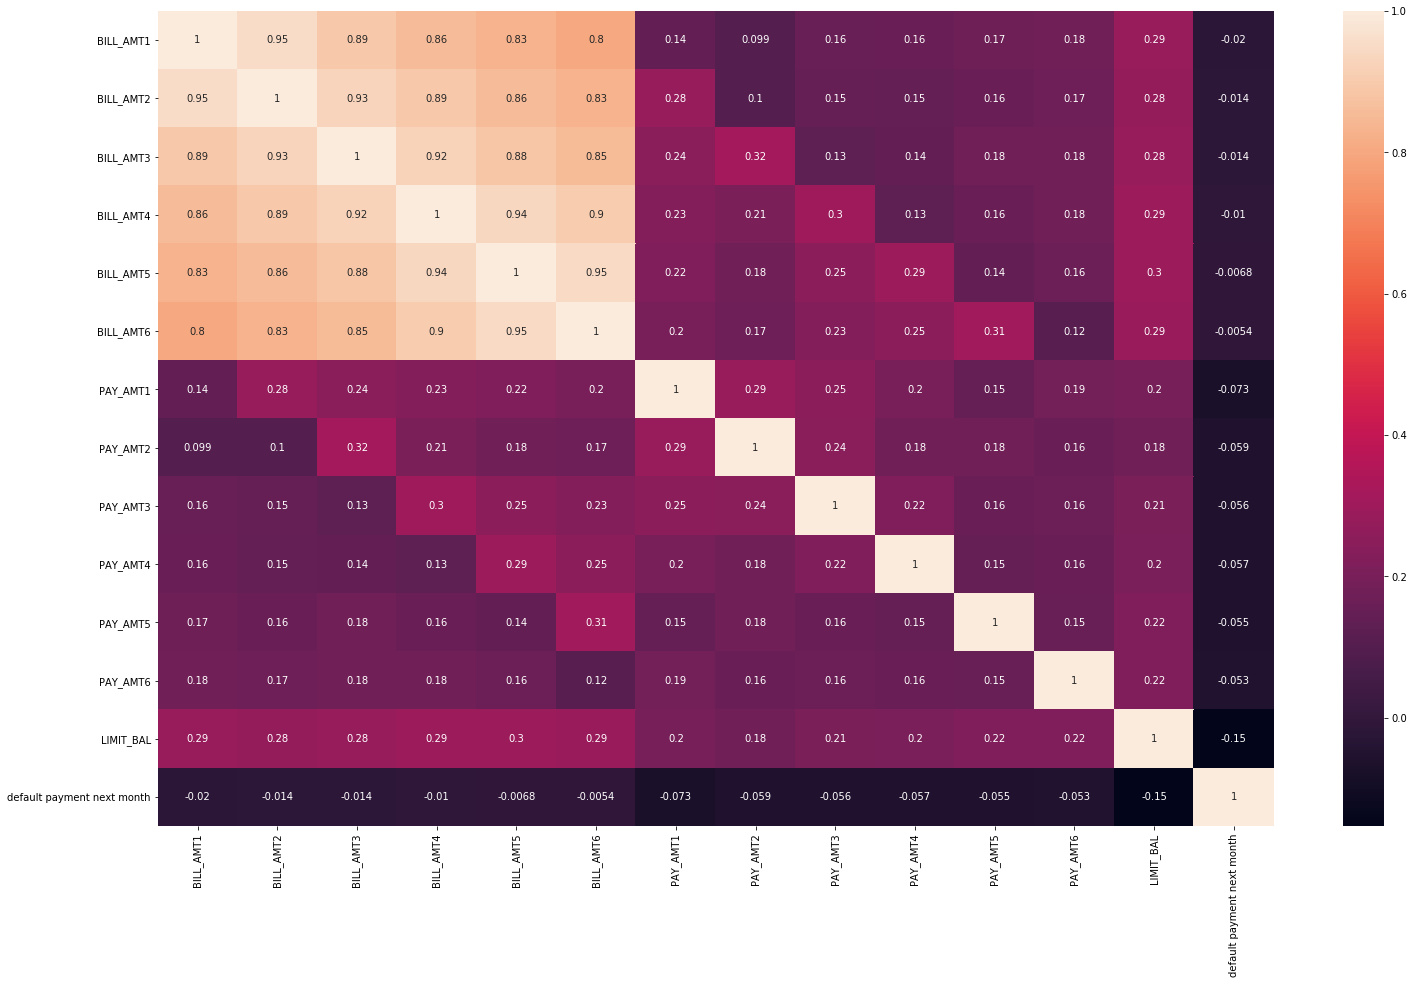

In [5]:
# correlation matrix for numerical features
num = bill+paid+['LIMIT_BAL']+['default payment next month']
plt.figure(figsize=(25,15))
sns.heatmap(df[num].corr(method='pearson'),annot=True)

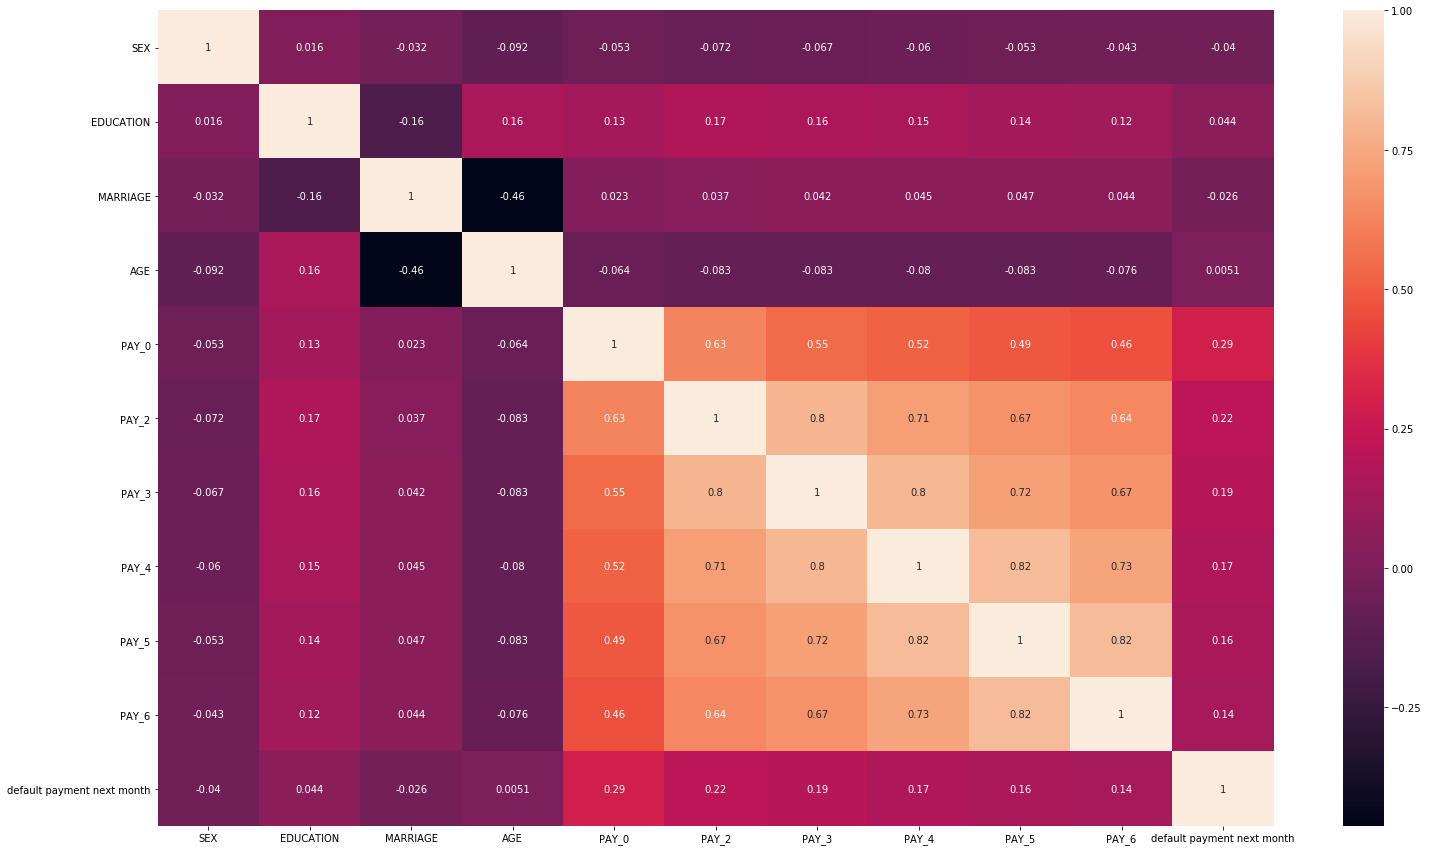

In [6]:
# correlation matrix for numerical features
cat = cat_features+['default payment next month']
plt.figure(figsize=(25,15))
sns.heatmap(df[cat].corr(method='spearman'),annot=True)

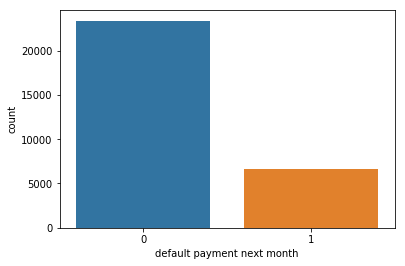

In [22]:
# check the dataset for imbalance
sns.countplot(y)
plt.savefig('imbalance.png')

### I have performed EDA for categorical variables
***
- Ifound that there are some unlabelled values in features Education, Marriage and Pay features
- After going through the related research paper and the comments from the author I found that the unlabelled data in Pay varaible is as follows
    - -2 is when a customer did not need to pay
    - 0 is when a customer has paid minimum balance    

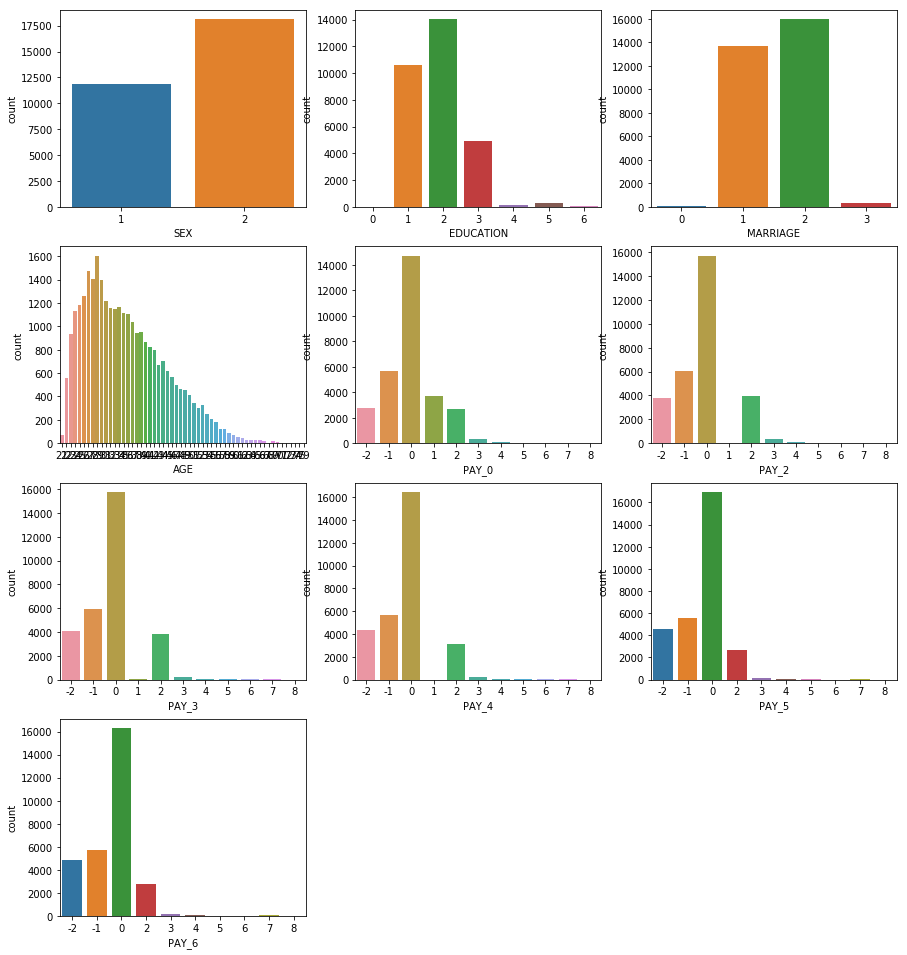

In [8]:
cat_univariate_eda(df, cat_features, save_fig = False)

### Pre-processing on categorical variables
***

- I have clubbed the unlabelled data in Education and Marriage feature as others
- I club certain categories of Pay feature, the reclassification is as follows
    - -1 - client did not need to pay or has paid fully
    - 0 - client has paid the minimum amount
    - 1 - client has made a delay of 1 or 2 months in payment
    - 2 - client has made a delay of 3+ months in payment 
- I have then applied one hot encoding to the categorical variables

In [9]:
y = df['default payment next month'].copy()
df.drop(labels='default payment next month', axis = 1,inplace=True)
df_cat = df[cat_features].copy()
df_ts = df[time_series].copy()

# adjust other values
fil = (df_cat.EDUCATION == 5) | (df_cat.EDUCATION == 6) | (df_cat.EDUCATION == 0)
df_cat.loc[fil, 'EDUCATION'] = 4
df_cat.EDUCATION.value_counts()
df_cat.loc[df_cat.MARRIAGE == 0, 'MARRIAGE'] = 3

#merge -2,-1,0 to 0 and assumed as paid duly
for c in pay:
    df_cat.loc[(df_cat[c]==-1) | (df_cat[c]==-2),c] = -1
    df_cat.loc[(df_cat[c]==1) | (df_cat[c]==2),c] = 1
    df_cat.loc[(df_cat[c]==3) | (df_cat[c]==4) | (df_cat[c]==5) | (df_cat[c]==6) | (df_cat[c]==7) | (df_cat[c]==8) | (df_cat[c]==9),c] = 2

# one hot encoding
df1 = pd.get_dummies(df_cat.SEX)
df1.rename(columns = {1:'Male',2:'Female'}, inplace = True)
df2 = pd.get_dummies(df_cat.MARRIAGE)
df2.rename(columns = {1:'Married',2:'Single',3:'Others'}, inplace = True)
df3 = pd.get_dummies(df_cat.EDUCATION)
df3.rename(columns = {1:'GS',2:'HS',3:'Univ',4:'Other'}, inplace = True)
df_cat = pd.concat([df_cat,df1,df2,df3], axis = 1)
df_cat.drop(labels=['SEX','MARRIAGE','EDUCATION'], axis =1, inplace = True)

## Multi-view learning
***
<img src='./images/model.png' width = '400' height = '300'>

we have taken an approach of multi-view learning, where we split the features apply different models and then combine all to make the final prediction.
 - In this example we have split the features in categorical and time series features.
 - We then apply Random Forest algoeithm to these two different datasets independently and then combine them by using stacking methodology to get final prediction

In [12]:
X = df_cat
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 3)

from imblearn.under_sampling import RandomUnderSampler

# Create the samplers
rus = RandomUnderSampler(random_state=3)
X_train2, y_train2 =  rus.fit_sample(X_train, y_train)

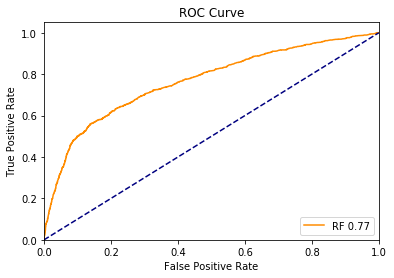

0.6198083067092651

In [13]:
rf_cat = RandomForestClassifier(random_state = 3, criterion='entropy', n_estimators=26, min_samples_leaf=9)
rf_cat.fit(X_train2, y_train2)
#y_pred = rf_cat.predict(X_test)
y_pred = pd.DataFrame(rf_cat.predict_proba(X_test))[1]
roc_auc_cat = roc_auc_score(y_test,y_pred)
ycat_score = pd.DataFrame(rf_cat.predict_proba(X_test))[1]
fpr,tpr, threshold = roc_curve(y_test, ycat_score)
plot_curve(rf_cat, X_test, y_test,roc_auc_cat, 'RF')
recall_score(y_test,rf_cat.predict(X_test))

In [14]:
# transforming the feature BILL_AMT to find the proportion of the LIMIT_BAL used
df_ts['BILL_AMT1'] = df_ts['BILL_AMT1']/df_ts['LIMIT_BAL']
df_ts['BILL_AMT2'] = df_ts['BILL_AMT2']/df_ts['LIMIT_BAL']
df_ts['BILL_AMT3'] = df_ts['BILL_AMT3']/df_ts['LIMIT_BAL']
df_ts['BILL_AMT4'] = df_ts['BILL_AMT4']/df_ts['LIMIT_BAL']
df_ts['BILL_AMT5'] = df_ts['BILL_AMT5']/df_ts['LIMIT_BAL']
df_ts['BILL_AMT6'] = df_ts['BILL_AMT6']/df_ts['LIMIT_BAL']

In [15]:
# scaling the LIMIT_BAL feature
df_ts['LIMIT_BAL'] = df_ts['LIMIT_BAL']/df_ts['LIMIT_BAL'].max()

In [16]:
Xts = df_ts
Xts_train, Xts_test, yts_train, yts_test = train_test_split(Xts,y, test_size = 0.2, random_state = 3)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# Create the samplers
rus = RandomUnderSampler(random_state=3)
Xts_train2, yts_train2 =  rus.fit_sample(Xts_train, yts_train)

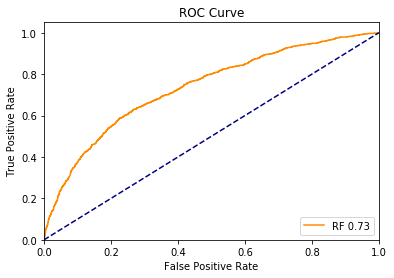

0.6757188498402555

In [17]:
rf_ts = RandomForestClassifier(random_state = 3, criterion='entropy', n_estimators=26, min_samples_leaf=5, max_depth = 9)
rf_ts.fit(Xts_train2, yts_train2)
#yts_pred = rf_ts.predict_proba(Xts_test)
yts_pred = pd.DataFrame(rf_ts.predict_proba(Xts_test))[1]

roc_auc_ts = roc_auc_score(yts_test,yts_pred)
yts_score = pd.DataFrame(rf_ts.predict_proba(Xts_test))[1]
plot_curve(rf_ts, Xts_test, yts_test,roc_auc_ts, 'RF')
recall_score(yts_test, rf_ts.predict(Xts_test))

In [18]:
df_lr1 = pd.DataFrame(rf_cat.predict_proba(X_train2))[1]
df_lr2 = pd.DataFrame(rf_ts.predict_proba(Xts_train2))[1]
meta_X = pd.concat([df_lr1, df_lr2], axis=1)

# fit meta classifier on validation set
meta_dt = RandomForestClassifier(random_state = 3, criterion='entropy', n_estimators=26, max_depth = 9, min_samples_leaf=5)
meta_dt.fit(meta_X,y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=26, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [19]:
meta_dt = RandomForestClassifier()
parameter = {
              'random_state':[1,2,3,4,5,6,7,8,9], 
              'n_estimators': [5,10,15,20,25], 
              'criterion': ['entropy','gini'],
              'max_depth': [3,5,7,9,11,13,15],
              'min_samples_leaf': [50,100,150] 
           } 
     
grid = gridfunc(meta_dt, parameter, meta_X, y_train2)
hp_cv_scores(grid)

0.774331352154532


/home/chinmay/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [20]:
meta_dt = RandomForestClassifier(random_state = 3, criterion='gini', n_estimators=10, max_depth = 15, min_samples_leaf=150)
meta_dt.fit(meta_X,y_train2)

df_testlr1 = pd.DataFrame(rf_cat.predict_proba(X_test))[1]
df_testlr2 = pd.DataFrame(rf_ts.predict_proba(Xts_test))[1]

meta_Xtest = pd.concat([df_testlr1, df_testlr2], axis=1)

#ypred = meta_dt.predict(meta_Xtest)
y_score = pd.DataFrame(meta_dt.predict_proba(meta_Xtest))[1]
y_pred = meta_dt.predict(meta_Xtest)
score = roc_auc_score(y_test, y_score)
recall = recall_score(y_test, y_pred)

print(score, recall)

0.7761990251149972 0.7324281150159745


### ROC Curve for the final model 

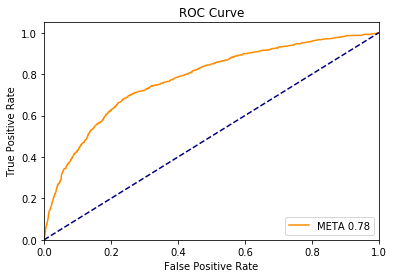

In [21]:
plot_curve(meta_dt, meta_Xtest, y_test,score, 'META')
